# Multi-variate Regression Metamodel with DOE based on random sampling
* Input variable space should be constructed using random sampling, not classical factorial DOE
* Linear fit is often inadequate but higher-order polynomial fits often leads to overfitting i.e. learns spurious, flawed relationships between input and output
* R-square fit can often be misleding measure in case of high-dimensional regression
* Metamodel can be constructed by selectively discovering features (or their combination) which matter and shrinking other high-order terms towards zero

#### LASSO: Least Absolute Shrinkage and Selection Operator
$$ {\displaystyle \min _{\beta _{0},\beta }\left\{{\frac {1}{N}}\sum _{i=1}^{N}(y_{i}-\beta _{0}-x_{i}^{T}\beta )^{2}\right\}{\text{ subject to }}\sum _{j=1}^{p}|\beta _{j}|\leq t.} $$

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Generate random feature vectors

In [6]:
X=np.array(10*np.random.randn(37,5))

In [7]:
df=pd.DataFrame(X,columns=['Feature'+str(l) for l in range(1,6)])

In [8]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5
0,-9.197722,4.567028,-19.139627,7.324951,-2.875343
1,-11.530007,15.922827,-14.619438,19.949263,-3.934784
2,-5.394335,9.472770,-18.105860,-17.175273,19.305739
3,-3.428133,-2.977308,-8.609464,4.870223,-11.723906
4,-2.345520,3.335209,-26.250114,-0.700562,0.540669


### Plot the random distributions of input features

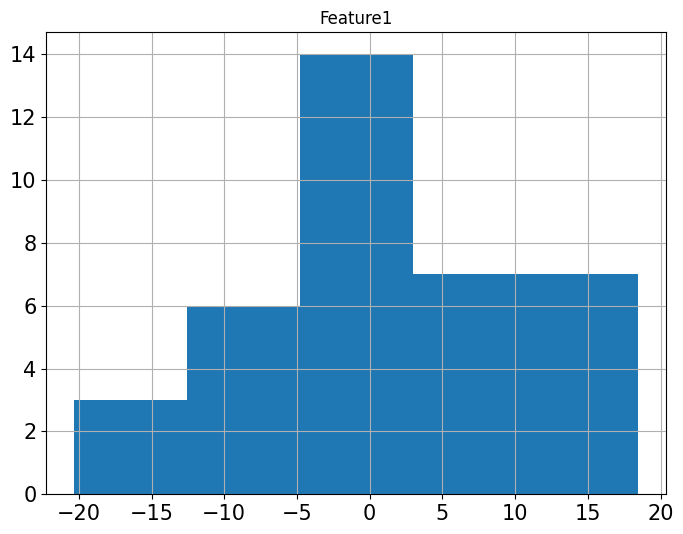

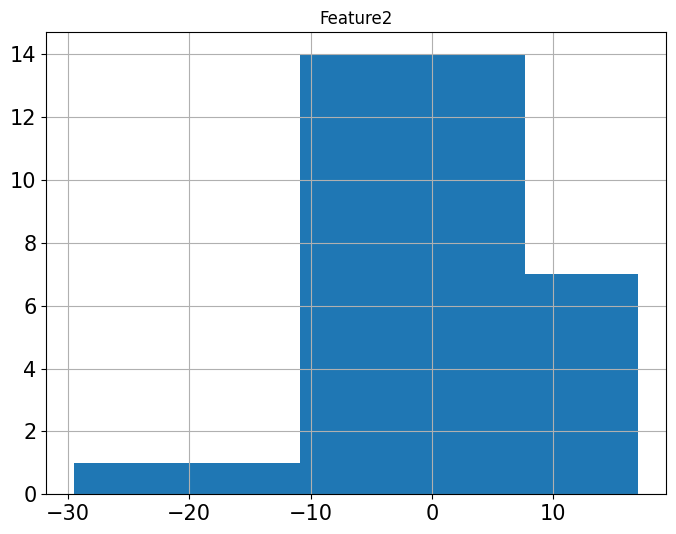

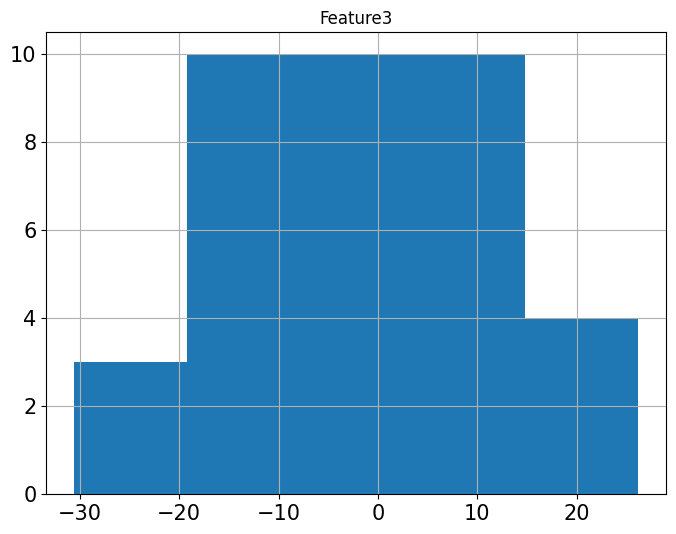

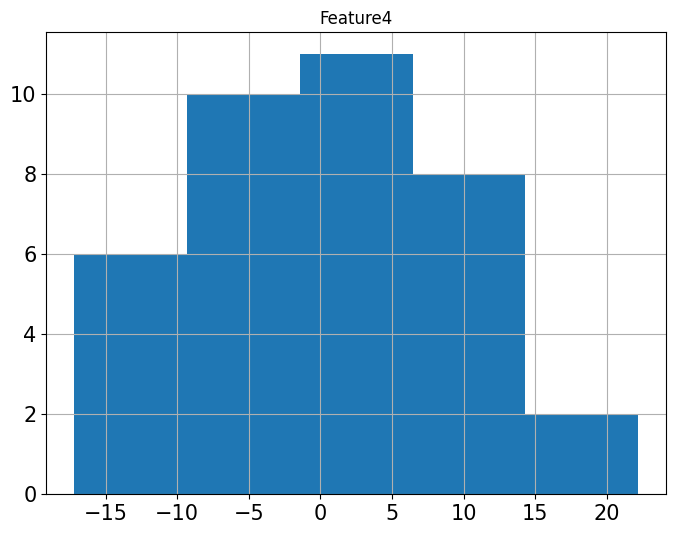

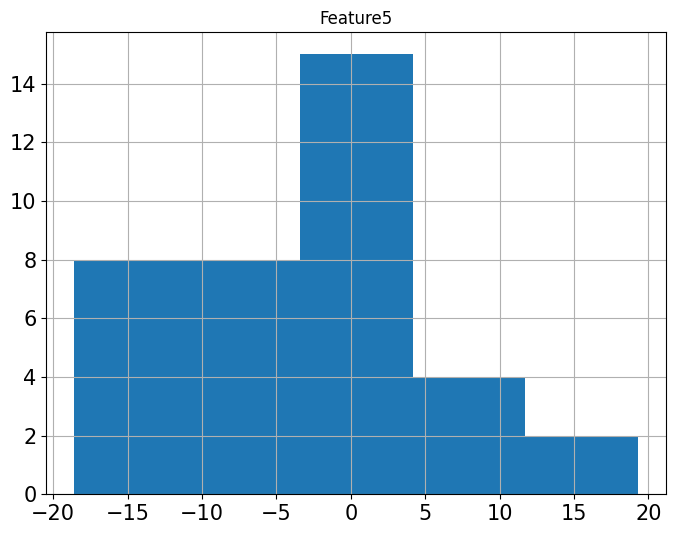

In [9]:
for i in df.columns:
    df.hist(i,bins=5,xlabelsize=15,ylabelsize=15,figsize=(8,6))

### Generate the output variable by analytic function + Gaussian noise (our goal will be to *'learn'* this function)

#### Let's construst the ground  truth  or  originating  function  as  follows: 
 
$$ y=f(x_1,x_2,x_3,x_4,x_5)= 5x_1^2+13x_2+0.1x_1x_3^2+2x_4x_5+0.1x_5^3+0.8x_1x_4x_5+\psi(x)\ :\ \psi(x) = {\displaystyle f(x\;|\;\mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}\;e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}}$$

In [10]:
df['y']=5*df['Feature1']**2+13*df['Feature2']+0.1*df['Feature3']**2*df['Feature1'] \
+2*df['Feature4']*df['Feature5']+0.1*df['Feature5']**3+0.8*df['Feature1']*df['Feature4']*df['Feature5'] \
+30*np.random.normal(loc=5,scale=2)

In [ ]:
df.head()


'Feature2'

### Plot single-variable scatterplots

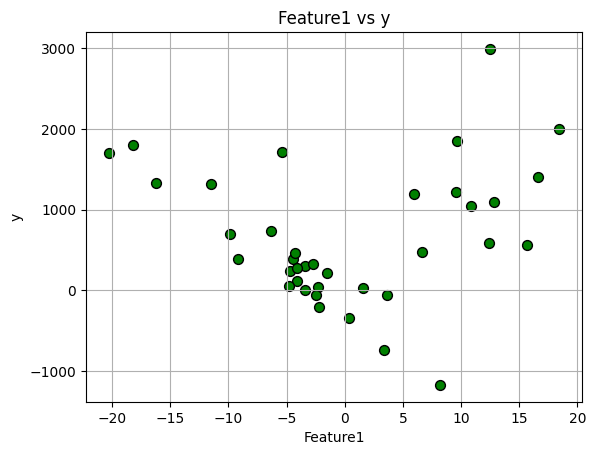

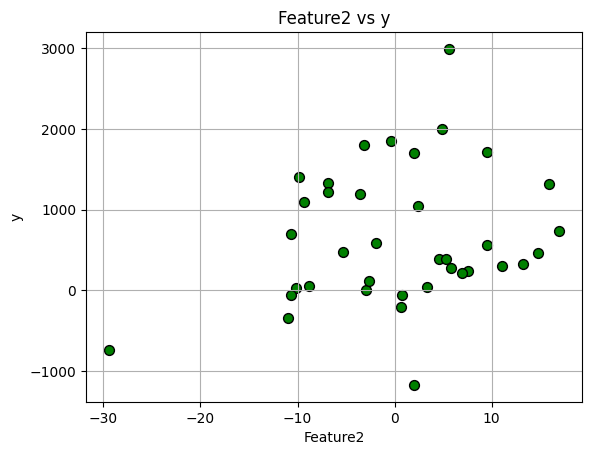

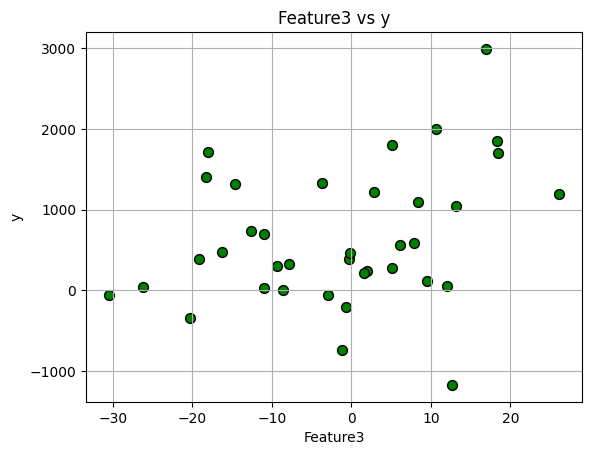

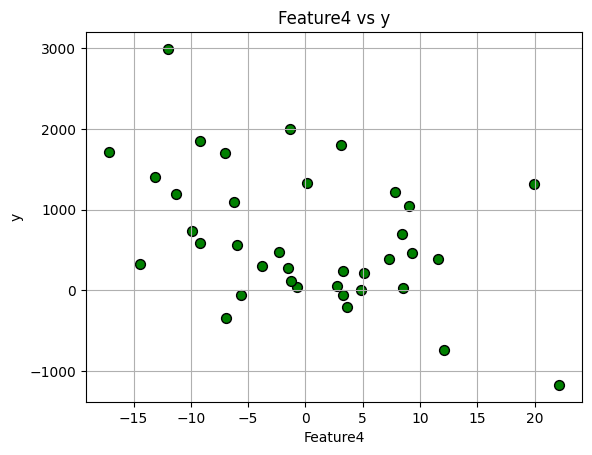

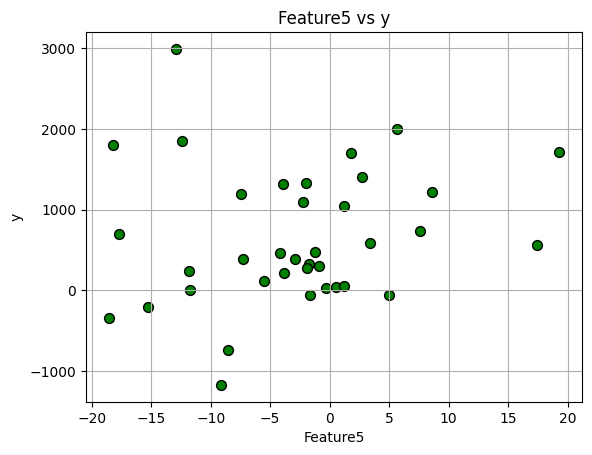

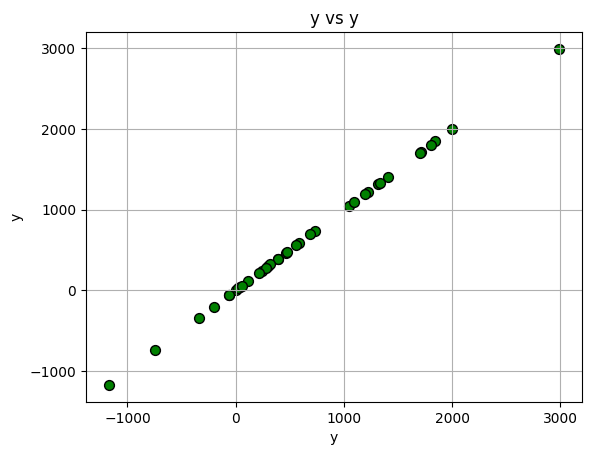

In [15]:
for i in df.columns:
    df.plot.scatter(i,'y', edgecolors=(0,0,0),s=50,c='g',grid=True, title= f"{i} vs y")


### Standard linear regression

In [16]:
from sklearn.linear_model import LinearRegression

In [18]:
linear_model = LinearRegression()

In [19]:
X_linear=df.drop('y',axis=1)
y_linear=df['y']

In [20]:
linear_model.fit(X_linear,y_linear)

LinearRegression()

In [21]:
y_pred_linear = linear_model.predict(X_linear)

### R-square of simple linear fit is very bad, coefficients have no meaning i.e. we did not 'learn' the function

In [22]:
RMSE_linear = np.sqrt(np.sum(np.square(y_pred_linear-y_linear)))

In [23]:
print("Root-mean-square error of linear model:",RMSE_linear)

Root-mean-square error of linear model: 4183.321327706681


In [24]:
coeff_linear = pd.DataFrame(linear_model.coef_,index=df.drop('y',axis=1).columns, columns=['Linear model coefficients'])
coeff_linear

,Linear model coefficients
Feature1,-4.672655
Feature2,16.429807
Feature3,19.175139
Feature4,-36.902874
Feature5,1.852926


In [25]:
print ("R2 value of linear model:",linear_model.score(X_linear,y_linear))

R2 value of linear model: 0.31431496454677754


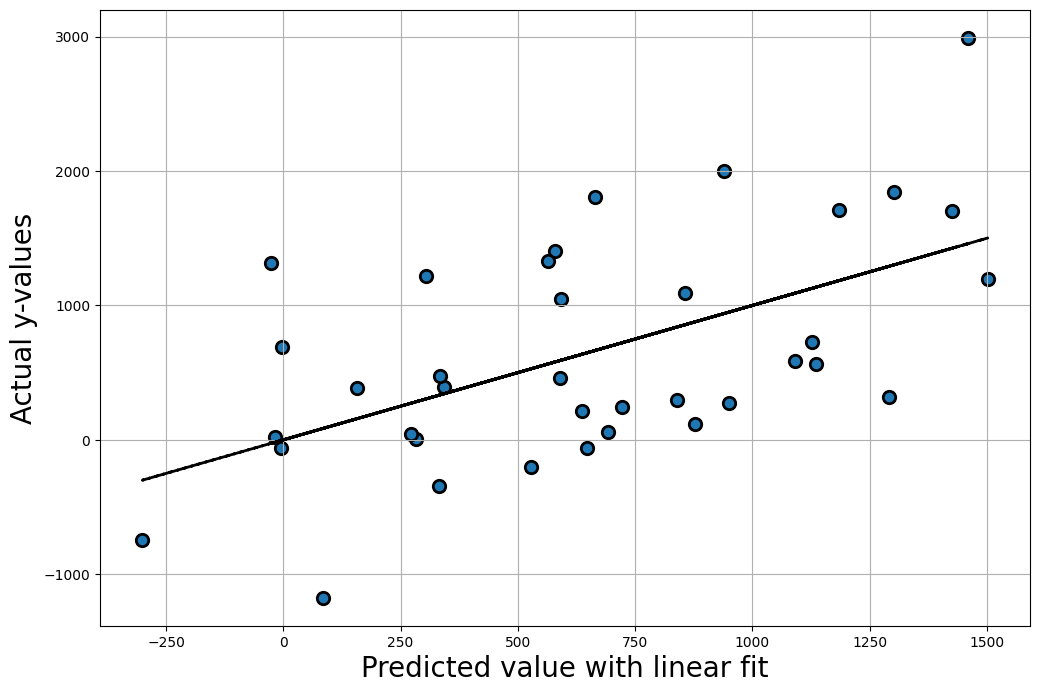

In [26]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with linear fit",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred_linear,y_linear,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred_linear,y_pred_linear, 'k--', lw=2)

### Create polynomial features

In [27]:
from sklearn.preprocessing import PolynomialFeatures

In [28]:
poly = PolynomialFeatures(3,include_bias=False)

In [30]:
X_poly = poly.fit_transform(X)
X_poly_feature_name = poly.get_feature_names_out(['Feature'+str(l) for l in range(1,6)])
print(X_poly_feature_name)
print(len(X_poly_feature_name))

['Feature1' 'Feature2' 'Feature3' 'Feature4' 'Feature5' 'Feature1^2'
 'Feature1 Feature2' 'Feature1 Feature3' 'Feature1 Feature4'
 'Feature1 Feature5' 'Feature2^2' 'Feature2 Feature3' 'Feature2 Feature4'
 'Feature2 Feature5' 'Feature3^2' 'Feature3 Feature4' 'Feature3 Feature5'
 'Feature4^2' 'Feature4 Feature5' 'Feature5^2' 'Feature1^3'
 'Feature1^2 Feature2' 'Feature1^2 Feature3' 'Feature1^2 Feature4'
 'Feature1^2 Feature5' 'Feature1 Feature2^2' 'Feature1 Feature2 Feature3'
 'Feature1 Feature2 Feature4' 'Feature1 Feature2 Feature5'
 'Feature1 Feature3^2' 'Feature1 Feature3 Feature4'
 'Feature1 Feature3 Feature5' 'Feature1 Feature4^2'
 'Feature1 Feature4 Feature5' 'Feature1 Feature5^2' 'Feature2^3'
 'Feature2^2 Feature3' 'Feature2^2 Feature4' 'Feature2^2 Feature5'
 'Feature2 Feature3^2' 'Feature2 Feature3 Feature4'
 'Feature2 Feature3 Feature5' 'Feature2 Feature4^2'
 'Feature2 Feature4 Feature5' 'Feature2 Feature5^2' 'Feature3^3'
 'Feature3^2 Feature4' 'Feature3^2 Feature5' 'Feature3 Fe

In [31]:
df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
df_poly.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature1 Feature4,Feature1 Feature5,...,Feature3^3,Feature3^2 Feature4,Feature3^2 Feature5,Feature3 Feature4^2,Feature3 Feature4 Feature5,Feature3 Feature5^2,Feature4^3,Feature4^2 Feature5,Feature4 Feature5^2,Feature5^3
0,-9.197722,4.567028,-19.139627,7.324951,-2.875343,84.598081,-42.006250,176.040956,-67.372864,26.446606,...,-7011.329585,2683.315082,-1053.310968,-1026.935011,403.114013,-158.238745,393.019636,-154.276289,60.559756,-23.772182
1,-11.530007,15.922827,-14.619438,19.949263,-3.934784,132.941050,-183.590298,168.562219,-230.015132,45.368086,...,-3124.582955,4263.715603,-840.973440,-5818.143094,1147.568053,-226.345831,7939.269928,-1565.938201,308.864980,-60.920396
2,-5.394335,9.472770,-18.105860,-17.175273,19.305739,29.098847,-51.099293,97.669071,92.649173,-104.141618,...,-5935.502624,-5630.435515,6328.849424,-5341.047944,6003.565464,-6748.263385,-5066.534030,5695.000128,-6401.422800,7195.471983
3,-3.428133,-2.977308,-8.609464,4.870223,-11.723906,11.752097,10.206608,29.514389,-16.695774,40.191109,...,-638.158215,360.994949,-869.009560,-204.208534,491.583520,-1183.370514,115.517199,-278.080206,669.412018,-1611.450366
4,-2.345520,3.335209,-26.250114,-0.700562,0.540669,5.501464,-7.822798,61.570167,1.643183,-1.268149,...,-18088.125813,-482.735368,372.557808,-12.883227,9.942812,-7.673505,-0.343827,0.265353,-0.204790,0.158050


In [32]:
df_poly['y']=df['y']
df_poly.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature1^2,Feature1 Feature2,Feature1 Feature3,Feature1 Feature4,Feature1 Feature5,...,Feature3^2 Feature4,Feature3^2 Feature5,Feature3 Feature4^2,Feature3 Feature4 Feature5,Feature3 Feature5^2,Feature4^3,Feature4^2 Feature5,Feature4 Feature5^2,Feature5^3,y
0,-9.197722,4.567028,-19.139627,7.324951,-2.875343,84.598081,-42.006250,176.040956,-67.372864,26.446606,...,2683.315082,-1053.310968,-1026.935011,403.114013,-158.238745,393.019636,-154.276289,60.559756,-23.772182,386.818408
1,-11.530007,15.922827,-14.619438,19.949263,-3.934784,132.941050,-183.590298,168.562219,-230.015132,45.368086,...,4263.715603,-840.973440,-5818.143094,1147.568053,-226.345831,7939.269928,-1565.938201,308.864980,-60.920396,1317.154376
2,-5.394335,9.472770,-18.105860,-17.175273,19.305739,29.098847,-51.099293,97.669071,92.649173,-104.141618,...,-5630.435515,6328.849424,-5341.047944,6003.565464,-6748.263385,-5066.534030,5695.000128,-6401.422800,7195.471983,1710.032188
3,-3.428133,-2.977308,-8.609464,4.870223,-11.723906,11.752097,10.206608,29.514389,-16.695774,40.191109,...,360.994949,-869.009560,-204.208534,491.583520,-1183.370514,115.517199,-278.080206,669.412018,-1611.450366,6.812890
4,-2.345520,3.335209,-26.250114,-0.700562,0.540669,5.501464,-7.822798,61.570167,1.643183,-1.268149,...,-482.735368,372.557808,-12.883227,9.942812,-7.673505,-0.343827,0.265353,-0.204790,0.158050,40.128728


In [33]:
X_train=df_poly.drop('y',axis=1)
y_train=df_poly['y']

### Polynomial model without regularization and cross-validation

In [35]:
poly = LinearRegression()

In [36]:
model_poly=poly.fit(X_train,y_train)
y_poly = poly.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
print("Root-mean-square error of simple polynomial model:",RMSE_poly)

Root-mean-square error of simple polynomial model: 1.59034258611326e-11


In [37]:
coeff_poly = pd.DataFrame(model_poly.coef_,index=df_poly.drop('y',axis=1).columns, 
                          columns=['Coefficients polynomial model'])
coeff_poly

,Coefficients polynomial model
Feature1,0.008116
Feature2,0.070485
Feature3,-0.147476
Feature4,-0.079054
Feature5,0.104272
Feature1^2,2.827629
Feature1 Feature2,-0.565866
Feature1 Feature3,1.043096
Feature1 Feature4,0.085529
Feature1 Feature5,-0.020965


#### R-square value of the simple polynomial model is perfect but the model is flawed as shown above i.e. it learned wrong coefficients and overfitted the to the data

In [38]:
print ("R2 value of simple polynomial model:",model_poly.score(X_train,y_train))

R2 value of simple polynomial model: 1.0


### Metamodel - polynomial model with cross-validation and LASSO regularization
** This is an advanced machine learning method which prevents over-fitting by penalizing high-valued coefficients i.e. keep them bounded **

In [39]:
from sklearn.linear_model import LassoCV

In [40]:
model1 = LassoCV(cv=10,verbose=0,eps=0.001,n_alphas=100, tol=0.0001,max_iter=5000)

In [41]:
model1.fit(X_train,y_train)

LassoCV(cv=10, max_iter=5000, verbose=0)

In [42]:
y_pred1 = np.array(model1.predict(X_train))

In [43]:
RMSE_1=np.sqrt(np.sum(np.square(y_pred1-y_train)))
print("Root-mean-square error of Metamodel:",RMSE_1)

Root-mean-square error of Metamodel: 253.7811488357226


In [44]:
coeff1 = pd.DataFrame(model1.coef_,index=df_poly.drop('y',axis=1).columns, columns=['Coefficients Metamodel'])
coeff1

,Coefficients Metamodel
Feature1,-0.000000
Feature2,0.000000
Feature3,-0.000000
Feature4,0.000000
Feature5,0.000000
Feature1^2,3.885865
Feature1 Feature2,0.000000
Feature1 Feature3,0.000000
Feature1 Feature4,0.000000
Feature1 Feature5,0.000000


In [45]:
model1.score(X_train,y_train)

0.9974765137652062

In [46]:
model1.alpha_

1717.9004927309388

#### Recall that the ground  truth  or  originating  function  is  as  follows: 
 
$$ y=f(x_1,x_2,x_3,x_4,x_5)= 5x_1^2+13x_2+0.1x_1x_3^2+2x_4x_5+0.1x_5^3+0.8x_1x_4x_5+\psi(x) $$

### Printing only the non-zero coefficients of the *metamodel*

In [47]:
coeff1[coeff1['Coefficients Metamodel']!=0]

,Coefficients Metamodel
Feature1^2,3.885865
Feature1^2 Feature2,-0.098811
Feature1^2 Feature3,0.076841
Feature1^2 Feature5,0.005385
Feature1 Feature2^2,-0.030050
Feature1 Feature2 Feature3,0.068681
Feature1 Feature3^2,0.120170
Feature1 Feature3 Feature4,0.040482
Feature1 Feature3 Feature5,0.063464
Feature1 Feature4 Feature5,0.838363


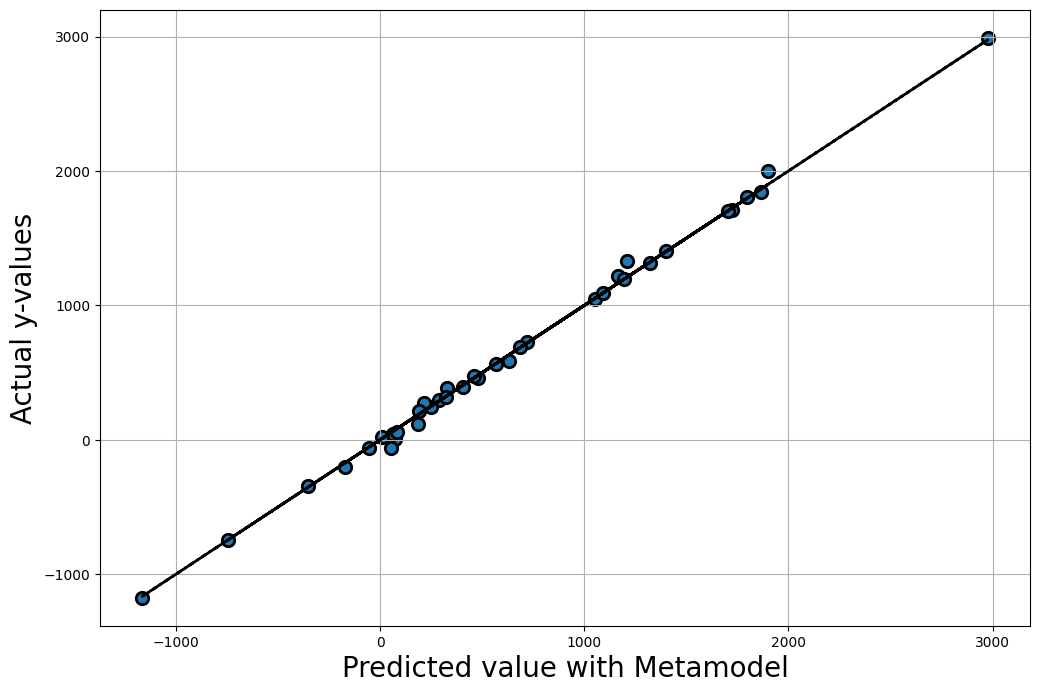

In [48]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with Metamodel",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred1,y_train,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred1,y_pred1, 'k--', lw=2)

(-6.38499800425108,
 -3.0849980042510796,
 -122357.01626133532,
 2585505.7646796987)

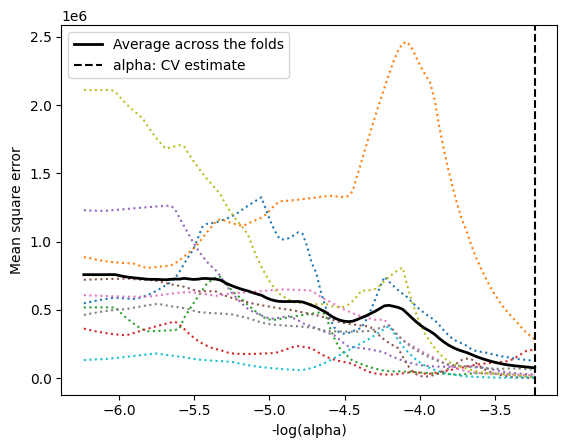

In [49]:
# Display results
m_log_alphas = -np.log10(model1.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model1.mse_path_, ':')
plt.plot(m_log_alphas, model1.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model1.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.axis('tight')